# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import os
import sys
import math
import gc

from copy import deepcopy

from itertools import chain

import numpy as np
import pandas as pd
from scipy.linalg import orth

import seaborn as sns

from scipy.spatial.distance import pdist, squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
device = None
os.environ["CUDA_VISIBLE_DEVICES"]="5"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    use_cuda = True

# Ignore cuda
use_cuda = False
device = None

# Set DoubleTensor as a base type for computations
t_type = torch.float64

In [2]:
import warnings
import functools

def deprecated(func):
    """This is a decorator which can be used to mark functions
    as deprecated. It will result in a warning being emitted
    when the function is used."""
    @functools.wraps(func)
    def new_func(*args, **kwargs):
        warnings.simplefilter('always', DeprecationWarning)  # turn off filter
        warnings.warn("Call to deprecated function {}.".format(func.__name__),
                      category=DeprecationWarning,
                      stacklevel=2)
        warnings.simplefilter('default', DeprecationWarning)  # reset filter
        return func(*args, **kwargs)
    return new_func

In [3]:
%load_ext line_profiler

# Support classes and functions

In [4]:
def pairwise_diffs(x, y, n_particles_second=True):
    '''
    Args:
        if n_particles_second == True:
            Input: x is a dxN matrix
                   y is an optional dxM matirx
            Output: diffs is a dxNxM matrix where diffs[i,j] is the subtraction between x[:,i] and y[:,j]
            i.e. diffs[i,j] = x[:,i] - y[:,j]

        if n_particles_second == False:
            Input: x is a Nxd matrix
                   y is an optional Mxd matirx
            Output: diffs is a NxMxd matrix where diffs[i,j] is the subtraction between x[i,:] and y[j,:]
            i.e. diffs[i,j] = x[i,:]-y[j,:]
    '''
    if n_particles_second:
        return x[:,:,np.newaxis] - y[:,np.newaxis,:]        
    return x[:,np.newaxis,:] - y[np.newaxis,:,:]

In [5]:
def pairwise_dists(diffs=None, n_particles_second=True):
    '''
    Args:
        if n_particles_second == True:
            Input: diffs is a dxNxM matrix where diffs[i,j] = x[:,i] - y[:,j]
            Output: dist is a NxM matrix where dist[i,j] is the square norm of diffs[i,j]
            i.e. dist[i,j] = ||x[:,i] - y[:,j]||

        if n_particles_second == False:
            Input: diffs is a NxMxd matrix where diffs[i,j] = x[i,:] - y[j, :]
            Output: dist is a NxM matrix where dist[i,j] is the square norm of diffs[i,j]
            i.e. dist[i,j] = ||x[i,:]-y[j,:]||
    '''
    if n_particles_second:
        return torch.norm(diffs, dim=0)
    return torch.norm(diffs, dim=2)

In [6]:
class normal_density():
    '''
        Multinomial normal density for independent random variables. 
    '''
    def __init__(self, n=1, mu=0., std=1., n_particles_second=True):
        '''
        Args:
            n (int): number of dimentions of multinomial normal distribution
                Default: 1
            mu (float, array_like): mean of distribution
                Default: 0.
                if mu is float - use same mean across all dimentions
                if mu is 1D array_like - use different mean for each dimention but same for each particles dimention
                if mu is 2D array_like - use different mean for each dimention
            std (float, array_like): std of distribution
                Default: 1.
                if std is float - use same std across all dimentions
                if std is 1D array_like - use different std for each dimention but same for each particles dimention
                if std is 2D array_like - use different std for each dimention
            n_particles_second (bool): specify type of input
                Default: True
                if n_particles_second == True - input must has shape [n, n_particles]
                if n_particles_second == False - input must has shape [n_particles, n]
                Therefore the same mu and std are applyed along particles axis
                Input will be reduced along all axis exclude particle axis
        '''
        
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.n_particles_second = n_particles_second
        
        self.mu = mu
        self.std = std
        
        if type(self.mu) == float:
            self.mu = torch.tensor(self.mu, dtype=t_type, device=device).expand(n)      
        if len(self.mu.shape) == 1:
            if self.mu.shape[0] == 1:
                self.mu = self.mu.view(1).expand(n)
            if self.n_particles_second:
                self.mu = torch.tensor(self.mu, dtype=t_type, device=device).view(n, 1)
            else:
                self.mu = torch.tensor(self.mu, dtype=t_type, device=device).view(1, n)
        elif len(self.mu.shape) == 2:
            self.mu = torch.tensor(self.mu, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        if type(self.std) == float:
            self.std = torch.tensor(self.std, dtype=t_type, device=device).expand(n)        
        if len(self.std.shape) == 1:
            if len(self.std) == 1:
                self.std = self.std.view(1).expand(n)
            if self.n_particles_second:
                self.std = torch.tensor(self.std, dtype=t_type, device=device).view(n, 1)
            else:
                self.std = torch.tensor(self.std, dtype=t_type, device=device).view(1, n)
        elif len(self.std.shape) == 2:
            self.std = torch.tensor(self.std, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        self.zero = torch.tensor(0., dtype=t_type, device=device)
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.pi = torch.tensor(math.pi, dtype=t_type, device=device)
        
        ### specify axis to reduce
        ### if n_particles_second == True - n_axis == 0
        ### if n_particles_second == False - n_axis == 1
        self.n_axis = 1 - int(self.n_particles_second)
        
    def __call__(self, x, n_axis=None):        
        '''
            Evaluate density in given point
        Args:
            x (torch.tensor): tensor which defines point where density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.pow(self.two * self.pi, -self.n / self.two) / 
                torch.prod(self.std, dim=n_axis) * 
                torch.exp(-self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis)))
    
    def unnormed_density(self, x, n_axis=None):      
        '''
            Evaluate unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return torch.exp(-self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std , self.two), dim=n_axis))
    
    def log_density(self, x, n_axis=None):  
        '''
            Evaluate log density in given point
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (-self.n / self.two * torch.log(self.two * self.pi) + 
                torch.sum(torch.log(self.std), dim=n_axis) -
                self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis))
                
    def log_unnormed_density(self, x, n_axis=None):
        '''
            Evaluate log unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return -self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis)
    
    def get_sample(self):
        '''
            Sample from normal distribution
        '''
        sample = torch.normal(self.mu, self.std)
        if self.n_particles_second:
            return sample.view(-1, 1)
        else:
            return sample.view(1, -1)

In [7]:
class gamma_density():
    '''
        Multinomial gamma density for independent random variables. 
    '''
    def __init__(self, n=1, alpha=1, betta=1, n_particles_second=True):
        '''
        Args:
            n (int): number of dimentions of multinomial normal distribution
                Default: 1
            alpha (float, array_like): shape of distribution
                Default: 1.
                if alpha is float - use same shape across all dimentions
                if alpha is 1D array_like - use different shape for each dimention but same for each particles dimention
                if alpha is 2D array_like - use different shape for each dimention
            betta (float, array_like): rate of distribution
                Default: 1.
                if betta is float - use same rate across all dimentions
                if betta is 1D array_like - use different rate for each dimention but same for each particles dimention
                if betta is 2D array_like - use different rate for each dimention
            n_particles_second (bool): specify type of input
                Default: True
                if n_particles_second == True - input must has shape [n, n_particles]
                if n_particles_second == False - input must has shape [n_particles, n]
                Therefore the same mu and std are applyed along particles axis  
        '''
        
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.n_particles_second = n_particles_second
        
        self.alpha = alpha
        self.betta = betta
        
        if type(self.alpha) == float:
            self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).expand(n)      
        if len(self.alpha.shape) == 1:
            if self.alpha.shape[0] == 1:
                self.alpha = self.alpha.view(1).expand(n)
            if self.n_particles_second:
                self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).view(n, 1)
            else:
                self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).view(1, n)
        elif len(self.alpha.shape) == 2:
            self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        if type(self.betta) == float:
            self.betta = torch.tensor(self.betta, dtype=t_type, device=device).expand(n)        
        if len(self.betta.shape) == 1:
            if len(self.betta) == 1:
                self.betta = self.betta.view(1).expand(n)
            if self.n_particles_second:
                self.betta = torch.tensor(self.betta, dtype=t_type, device=device).view(n, 1)
            else:
                self.betta = torch.tensor(self.betta, dtype=t_type, device=device).view(1, n)
        elif len(self.std.shape) == 2:
            self.betta = torch.tensor(self.betta, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        
        ### specify axis to reduce
        ### if n_particles_second == True - n_axis == 0
        ### if n_particles_second == False - n_axis == 1
        self.n_axis = 1 - int(self.n_particles_second)
        
        ### log Г(alpha)
        self.lgamma = torch.lgamma(self.alpha)
        ### Г(alpha)
        self.gamma = torch.exp(self.lgamma)

    def __call__(self, x, n_axis=None):
        '''
            Evaluate density in given point
        Args:
            x (torch.tensor): tensor which defines point where density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.prod(torch.pow(self.betta, self.alpha) / self.gamma * torch.pow(x, self.alpha - self.one), dim=n_axis) * 
                torch.exp(-torch.sum(self.betta * x, dim=n_axis)))
    
    def unnormed_density(self, x, n_axis=None):
        '''
            Evaluate unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.prod(torch.pow(x, self.alpha - self.one), dim=n_axis) * 
                torch.exp(-torch.sum(self.betta * x, dim=n_axis)))
    
    def log_density(self, x, n_axis=None):
        '''
            Evaluate log density in given point
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum(self.alpha * torch.log(self.betta) - self.lgamma + (self.alpha - self.one) * torch.log(x), dim=n_axis) -
                torch.sum(self.betta * x, dim=n_axis))
                
    def log_unnormed_density(self, x, n_axis=None):
        '''
            Evaluate log unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum((self.alpha - self.one) * torch.log(x), dim=n_axis) -
                torch.sum(self.betta * x, dim=n_axis))
                
    def log_density_log_x(self, log_x, n_axis=None):
        '''
            Evaluate log density in point log(x)
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum(self.alpha * torch.log(self.betta) - self.lgamma + (self.alpha - self.one) * log_x, dim=n_axis) -
                torch.sum(self.betta * torch.exp(log_x), dim=n_axis))
                
    def log_unnormed_density_log_x(self, log_x, n_axis=None):
        '''
            Evaluate log unnormed density in point log(x)
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        '''
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum((self.alpha - self.one) * log_x, dim=n_axis) -
                torch.sum(self.betta * torch.exp(log_x), dim=n_axis))

In [8]:
class SteinLinear(nn.Module):
    '''
        Custom full connected layer for Stein Gradient Neural Networks
        Transformation: y = xA + b
        Parameters prior: p(w, a) = p(w|a)p(a) = П p(w_i|a_i)p(a_i)
                          p(w_i|a_i) = N(w_i|0, a_i^(-1)); p(a_i) = G(1e-4, 1e-4)
    '''
    def __init__(self, in_features, out_features, n_particles=1, bias=True):
        super(SteinLinear, self).__init__()
        '''
        Args:
            in_features (int): size of each input sample
            out_features (int): size of each output sample
            n_particles (int): number of particles
            bias (bool): If set to False, the layer will not learn an additive bias.
                Default: ``True``
        '''
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_particles = n_particles
        
        
        self.weight = torch.nn.Parameter(torch.zeros([in_features, out_features, n_particles], dtype=t_type, device=device))
        self.log_weight_alpha = torch.nn.Parameter(torch.zeros([in_features * out_features, n_particles], dtype=t_type, device=device))
        
        self.bias = None
        self.log_bias_alpha = None
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros([1, out_features, n_particles], dtype=t_type, device=device))
            self.log_bias_alpha = torch.nn.Parameter(torch.zeros([out_features, n_particles], dtype=t_type, device=device))
        else:
            self.register_parameter('bias', None)
        
        ### define prior on alpha p(a) = G(1e-4, 1e-4)
        self.weight_alpha_log_prior = lambda x: (gamma_density(n=self.log_weight_alpha.shape[0],
                                                               alpha=1e-4,
                                                               betta=1e-4,
                                                               n_particles_second=True
                                                              ).log_unnormed_density_log_x(x))
        self.bias_alpha_log_prior = lambda x: (gamma_density(n=self.log_bias_alpha.shape[0],
                                                             alpha=1e-4,
                                                             betta=1e-4,
                                                             n_particles_second=True
                                                            ).log_unnormed_density_log_x(x))
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        
        self.reset_parameters()
        
    ### useless function - all initialization defined in DistributionMover class
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.out_features)
        self.weight.data.uniform_(-stdv, stdv)
        self.log_weight_alpha.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            self.log_bias_alpha.data.uniform_(-stdv, stdv)
            
    def forward(self, X):
        '''
            Apply transformation: X_out[i, :, :] = X_in[i, :, :] * W + b[i]
        Args:
            X (torch.tensor): tensor 
        Shape:
            Input: [n_particles, batch_size, in_features]
            Output: [n_particles, batch_size, out_features]
        '''
        ### NEED SOME OPTIMIZATION TO OMMIT .permute
        return torch.bmm(X, self.weight.permute(2, 0, 1)) + self.bias.permute(2, 0, 1)
    
    def numel(self, trainable=True):
        '''
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        '''
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())
        
    def calc_log_prior(self):
        '''
            Evaluate log prior of trainable parameters
        log p(w,a) = log p(w|a) + log p(a
        '''
        ### define prior on weight p(w|a) = N(0, 1 / alpha)
        self.weight_log_prior = lambda x: (normal_density(n=self.weight.numel() // self.n_particles,
                                                          mu=0.,
                                                          std=self.one / torch.exp(self.log_weight_alpha),
                                                          n_particles_second=True
                                                         ).log_unnormed_density(x))
        
        self.bias_log_prior = lambda x: (normal_density(self.bias.numel() // self.n_particles,
                                                        mu=0.,
                                                        std=self.one / torch.exp(self.log_bias_alpha),
                                                        n_particles_second=True
                                                       ).log_unnormed_density(x))
        
        return (self.weight_log_prior(self.weight.view(-1, self.n_particles)) + self.weight_alpha_log_prior(self.log_weight_alpha) +
                self.bias_log_prior(self.bias.view(-1, self.n_particles)) + self.bias_alpha_log_prior(self.log_bias_alpha))

In [9]:
class LinearTransform():
    '''
        Class for various linear transformations
    '''
    def __init__(self, n_dims, n_hidden_dims, use_identity=False, normalize=False):
        '''
        Args:
            n_dims (int): dimension of the space
            n_hidden_dims (int): dimension of the latent space
            use_identity (bool): If set to True, use 'eye' matrix for transformations
            normalize (bool): If set to True, columns of the transformation matrix is an orthonormal basis 
        '''
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_identity = use_identity
        self.normalize = normalize
        
        if self.use_identity:
            return
        
        self.A = torch.zeros([self.n_dims, self.n_hidden_dims], dtype=t_type, device=device)
        self.tetta_0 = torch.zeros([self.n_dims, 1], dtype=t_type, device=device)
        if not self.use_identity: 
            self.A.uniform_(-1., 1.)
            self.tetta_0.uniform_(-1.,1.)
        else:
            if self.n_dims != self.n_hidden_dims:
                raise RuntimeError("Cannot use identity transformation in spaces with differrent dimensions")
            self.A = torch.eye(self.n_dims)
            
        ### normalize columns of matrix A
        if self.normalize:
            self.A = torch.tensor(orth(self.A.data.numpy()), dtype=t_type, device=device)
        #self.A /= self.A.norm(dim=0)
        
        ### A^(t)A
        self.AtA = torch.matmul(self.A.t(), self.A)
        ### (A^(t)A)^(-1)
        self.AtA_1 = torch.inverse(self.AtA)
        ### (A^(t)A)^(-1)A^(t)
        self.inverse_base = torch.matmul(self.AtA_1, self.A.t())
#         ### A(A^(t)A)^(-1)A^(t)
#         self.projector_base = torch.matmul(self.A, self.inverse_base)
        
    def transform(self, tetta, n_particles_second=True):
        '''
            Transform tettas as follows: 
                tetta = Atetta` + tetta_0
        '''
        if self.use_identity:
            return tetta
        if n_particles_second:
            return torch.matmul(self.A, tetta) + self.tetta_0
        return (torch.matmul(self.A, tetta.t()) + self.tetta_0).t()
    
    def inverse_transform(self, tetta, n_particles_second=True):
        '''
            Apply inverse transformation: 
                tetta` = (A^(t)A)^(-1)A^(t)(tetta - tetta_0)
        '''
        if self.use_identity:
            return tetta
        if n_particles_second:
            return torch.matmul(self.inverse_base, tetta - self.tetta_0)
        return torch.matmul(self.inverse_base, tetta.t() - self.tetta_0).t()
        
    def project(self, tetta, n_particles_second=True):
        '''
            Project tettas onto Linear Space X = {Atetta` + tetta_0 for all tetta` in R^d}:
                tetta_projected = A(A^(t)A)^(-1)A^(t)(tetta - tetta_0) + tetta_0
        '''
        if self.use_identity:
            return tetta
        if n_particles_second:
            return torch.matmul(self.projector_base, tetta - self.tetta_0) + self.tetta_0
        return (torch.matmul(self.projector_base, tetta.t() - self.tetta_0) + self.tetta_0).t()
    
    def project_inverse(self, tetta, n_particles_second=True):
        '''
            Project and then apply inverse transform to tetta - tetta_0:
                tetta_s_p_i = T^(-1)P(tetta - tetta_0)= (A^(t)A)^(-1)A^(t)tetta
        '''
        if self.use_identity:
            return tetta
        ### use solver trick: tetta_s_p_i : A^(t)Atetta_s_p_i = A^(t)tetta
        if n_particles_second:
            return torch.gesv(torch.matmul(self.A.t(), tetta), self.AtA)[0]
        return torch.gesv(torch.matmul(self.A.t(), tetta.t()), self.AtA)[0].t()

In [10]:
class RegressionDistribution(nn.Module):
    '''
        Distribution over data for regression task: p(D|w) = N(y_predicted|y, )
    '''
    def __init__(self, n_particles):
        super(RegressionDistribution, self).__init__()
        '''
        Args:
            n_particles (int): number of particles
        '''
        
        self.n_particles = n_particles
        
        ### define betta - variance of data distribution for regression tasks (betta = 1 / std ** 2)
        self.log_betta = torch.nn.Parameter(torch.zeros([1, self.n_particles], dtype=t_type, device=device))
        
        ### define prior on betta p(betta)
        self.betta_log_prior = lambda x: (gamma_density(n=1,
                                                        alpha=1e-4,
                                                        betta=1e-4,
                                                        n_particles_second=True
                                                       ).log_unnormed_density_log_x(x))
        
        ### Support tensors for computations
        self.one = torch.tensor(1., dtype=t_type, device=device)
    
    def calc_log_data(self, X, y, y_predict, train_size):  
        '''
            Evaluate log p(tetta) 
        Args:
            X (array_like): batch of data
            y (array_like): batch of target values
            y_predict (array_like): batch of predicted values
            train_size (int) - size of training dataset
        Shapes:
            y.shape = [batch_size]
            y_predict.shape = [n_particles, batch_size, 1]
        '''
        ### squeeze last axis because regression task is being solved
        y_predict.squeeze_(2)
        
        batch_size = torch.tensor(y.shape[0], dtype=t_type, device=device)
        train_size = torch.tensor(train_size, dtype=t_type, device=device)
        
        ### define distribution over data p(D|w)
        ### n_particles_second == False because y_predict has shape = [n_particles, batch_size]
        self.log_data_distr = lambda x: (normal_density(n=X.shape[0],
                                                        mu=y,
                                                        std=self.one / torch.sqrt(torch.exp(self.log_betta.expand(X.shape[0], self.n_particles).t())),
                                                        n_particles_second=False
                                                       ).log_unnormed_density(x))

        return train_size / batch_size * self.log_data_distr(y_predict) + self.betta_log_prior(self.log_betta)
    
    def modules(self):
        yield self
    
    def numel(self, trainable=True):
        '''
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        '''
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())

In [11]:
class ClassificationDistribution(nn.Module):
    def __init__(self, n_particles):
        super(ClassificationDistribution, self).__init__()
        '''
        Args:
            n_particles (int): number of particles
        '''
        self.n_particles = n_particles
    

    def calc_log_data(self, X, y, y_predict, train_size):  
        '''
            Evaluate log p(tetta) 
        Args:
            X (array_like): batch of data
            y (array_like): batch of target values
            y_predictions (array_like): batch of predictions
            train_size (int): size of train dataset
        Shapes: 
            X.shape = [batch_size, in_features]
            y.shape = [batch_size]
            y_predict.shape = [n_particles, batch_size, n_classes]
        '''
        batch_size = torch.tensor(X.shape[0], dtype=t_type, device=device)
        train_size = torch.tensor(train_size, dtype=t_type, device=device)
        
        ### define distribution over data p(D|w)
        ### n_particles_second == False because y_predict has shape = [n_particles, batch_size]
        
        probas = nn.LogSoftmax(dim=2)(y_predict)
        probas_selected = torch.gather(input=probas, dim=2, index=y.view(1, -1, 1).expand(probas.shape[0], probas.shape[1], 1)).squeeze(2)
        log_data = torch.sum(probas_selected, dim=1)
        
        return train_size / batch_size  * log_data
    
    def modules(self):
        yield self
    
    def numel(self, trainable=True):
        '''
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        '''
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())

In [12]:
class DistributionMover():
    def __init__(self,
                 task='app', 
                 n_particles=None,
                 particles=None,
                 target_density=None,
                 n_dims=None,
                 n_hidden_dims=None,
                 use_latent=False,
                 net=None,
                 precomputed_params=None,
                 data_distribution=None):
        '''
        Args:
            task (str):
                'app' | 'reg' | 'net_reg' | 'net_class'
                - approximate target distribution
                - @deprecated solve regression task inplace
                - solve regression task using net
                - solve classification task using net
            n_particles (int): number of particles
            particles (2D array_like): array which contains initialized particles
            target_density (callable): computes probability density function of target distribution (only for 'app' task)
            n_dims (int): dimension of the space where optimization is performed
            n_hidden_dims (int): dimension of the latent space
            use_latent (bool): If set to True, Subspace Stein is used
            net (nn.Sequential): object which is used to make predictions (for 'net_reg' and' net_class' tasks)
            precomputed_params (1D array_like): Precomputed parameters, which will be used for particles initialization
            data_distribution (callable): computes probability over data p(D|w) (for 'net_reg' and' net_class' tasks)
        '''
        
        self.task = task
        
        self.n_particles = n_particles
        self.particles = particles
        self.target_density = target_density
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_latent = use_latent
        self.net = net
        self.precomputed_params = precomputed_params
        self.data_distribution = data_distribution
        

        if self.task == 'net_reg' or self.task == 'net_class':
            self.n_dims = 0
            for module in self.modules_net():
                if "numel" in dir(module):
                    self.n_dims += module.numel() // self.n_particles

        if not self.use_latent:
            self.n_hidden_dims = self.n_dims

        ### Learnable samples from the target distribution
        self.particles = torch.zeros(
            [self.n_hidden_dims, self.n_particles],
            dtype=t_type,
            requires_grad=False,
            device=device).uniform_(-2., 2.)

        ### Class for performing linear transformations
        self.lt = None
        if self.use_latent:
            self.lt = LinearTransform(
                n_dims=self.n_dims,
                n_hidden_dims=self.n_hidden_dims,
                use_identity=False, 
                normalize=True
            )
        else:
            self.lt = LinearTransform(
                n_dims=self.n_dims,
                n_hidden_dims=self.n_hidden_dims,
                use_identity=True, 
                normalize=True
            )
            
        if self.precomputed_params is not None:
            self.particles = self.lt.inverse_transform(self.precomputed_params.unsqueeze(1).expand(self.n_dims, self.n_particles))

        ### Functions of probability density of target distribution
        self.target_density = None
        self.real_target_density = None
        if self.net is None:
            # use unnormed probability density to speedup computations
            if target_density is not None:
                self.target_density = target_density
                self.real_target_density = target_density
            else:
                self.target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs) +
                                                                   0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs))

                self.real_target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True)(x, *args, **kwargs) +
                                                                        0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True)(x, *args, **kwargs))

                # self.target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True).unnormed_density(x))

                # self.real_target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True)(x))

        ### Number of iterations since begining
        self.iter = 0

        ### Adagrad parameters
        self.fudge_factor = torch.tensor(1e-6, dtype=t_type, device=device)
        self.step_size = torch.tensor(1e-2, dtype=t_type, device=device)
        self.auto_corr = torch.tensor(0.9, dtype=t_type, device=device)

        ### Gradient history term for adagrad optimization
        self.historical_grad = None
        if self.use_latent:
            self.historical_grad = torch.zeros(
                [self.n_hidden_dims, n_particles], dtype=t_type, device=device)
        else:
            self.historical_grad = torch.zeros(
                [self.n_dims, n_particles], dtype=t_type, device=device)

        ### Factor from kernel
        self.med = torch.tensor(0., dtype=t_type, device=device)
        self.h = torch.tensor(0., dtype=t_type, device=device)

        ### Support tensors for computations
        self.N = torch.tensor(self.n_particles, dtype=t_type, device=device)
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.three = torch.tensor(3., dtype=t_type, device=device)

    @deprecated # use calc_kernel_term_latent / calc_kernel_term_latent_net
    def calc_kernel_term(self, h_type):
        '''
            Calculate k(*,*), grad(k(*,*))
        Args:
            h_type (int, float): 
                If float then use h_type as kernel factor
                If int: 0 | 1 | 2 | 3 | 4:
                    - med(dist(tetta-tetta`)^2) / logN
                    - med(dist(tetta-tetta`)^2) / logN * n_dims
                    - med(dist(tetta-tetta`)) / logN * 2 * n_dims
                    - var(tetta) / logN * 2 * n_dims
                    - var(diff(tetta-tetta`) / logN * n_dims
        Shape:
            Output: 
                ([n_particles, n_particles], [n_dims, n_particles, n_particles])
        '''
        ### diffs[i, j] = tetta_i - tetta_j
        diffs = pairwise_diffs(self.particles, self.particles, n_particles_second=True)
        ### dists[i, j] = ||tetta_i - tetta_j||
        dists = pairwise_dists(diffs=diffs, n_particles_second=True)
        ### sq_dists[i, j] = ||tetta_i - tetta_j||^2
        sq_dists = torch.pow(dists, self.two)

        ### RBF Kernel
        if type(h_type) == float:
            self.h = h_type
        elif h_type == 0:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)
        elif h_type == 1:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (self.n_dims)
        elif h_type == 2:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (2. * self.n_dims)
        elif h_type == 3:
            self.var = torch.var(self.particles) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1.) * (2. * self.n_dims)
        elif h_type == 4:
            self.var = torch.var(diffs) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1) * (self.n_dims)

        kernel = torch.exp(-self.one / self.h * sq_dists)

        grad_kernel = -self.two / self.h * kernel.unsqueeze(dim=0) * diffs

        return kernel, grad_kernel

    def calc_kernel_term_latent(self, h_type, kernel_type='rbf', p=None):
        '''
            Calculate k(*,*), grad(k(*,*))
        Args:
            h_type (int, float): 
                If float then use h_type as kernel factor
                If int: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7:
                    0 - med(dist(tetta-tetta`)^2) / logN
                    1 - med(dist(tetta-tetta`)^2) / logN * n_dims
                    2 - med(dist(tetta-tetta`)) / logN * 2 * n_dims
                    3 - var(tetta) / logN * 2 * n_dims
                    4 - var(diff(tetta-tetta`) / logN * n_dims
                    5 - med(dist(tetta-tetta`)^2) / (N^2 - 1)
                    6 - med(dist(tetta-tetta`)^2) / (N^(-1/p) - 1)
                    7 - -med(<Atetta`_i + tetta_0, Atetta`_j + tetta_0>) / logN
            kernel_type (std):
                'rbf' | 'imq' | 'exp' | 'rat'
                    - kernel[i, j] = exp(-1/h * ||A(tetta`_i - tetta`_j)||^2)
                    - kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(-1/2)
                    - kernel[i, j] = exp(1/h * <Atetta`_i + tetta_0, Atetta`_j + tetta_0>)
                    - kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(p)
                Default: 'rbf'
            p (double, None): power in rational kernel 
                If kernel_type == 'rat' then p must be not None
                Default: None
        Shape:
            Output: 
                ([n_particles, n_particles], [n_dims, n_particles, n_particles])
        '''
        ### power for rational kernel
        self.p = torch.tensor(p, dtype=t_type, device=device) if p is not None else None
        
        ### tetta = Atetta` + tetta_0
        real_particles = self.lt.transform(self.particles, n_particles_second=True)
        ### diffs[i, j] = A(tetta`_i - tetta`_j)
        diffs = pairwise_diffs(real_particles, real_particles, n_particles_second=True)
        ### dists[i, j] = ||A(tetta`_i - tetta`_j)||
        dists = pairwise_dists(diffs=diffs, n_particles_second=True)
        ### sq_dists[i, j] = ||A(tetta`_i - tetta`_j)||^2
        sq_dists = torch.pow(dists, self.two)

        if type(h_type) == float:
            self.h = h_type
        elif h_type == 0:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)
        elif h_type == 1:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (self.n_dims)
        elif h_type == 2:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (2. * self.n_dims)
        elif h_type == 3:
            self.var = torch.var(self.particles) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1.) * (2. * self.n_dims)
        elif h_type == 4:
            self.var = torch.var(diffs) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1) * (self.n_dims)
        elif h_type == 5:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h =  self.med / (torch.pow(self.N, self.two) - self.one)
        elif h_type == 6:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h =  self.med / (torch.pow(self.N, -self.one / self.p) - self.one)
        elif h_type == 7:
            self.med = torch.median(torch.matmul(real_particles.t(), real_particles)) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)
        
        kernel = None
        grad_kernel = None
        if kernel_type == 'rbf':
            ### RBF Kernel:
            ### kernel[i, j] = exp(-1/h * ||A(tetta`_i - tetta`_j)||^2)
            kernel = torch.exp(-self.one / self.h * sq_dists)
            ### grad_kernel[i, j] = -2/h * A(tetta`_i - tetta`_j) * kernel[i, j]
            grad_kernel = -self.two / self.h * kernel.unsqueeze(0) * diffs
        elif kernel_type == 'imq':
            ### IMQ Kernel:
            ### kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(-1/2)
            kernel = torch.pow(self.one + self.one / self.h * sq_dists, -self.one / self.two)
            ### grad_kernel[i, j] = -1/h * A(tetta`_i - tetta`_j) * kernel^(3)[i, j]
            grad_kernel = -self.one / self.h * torch.pow(kernel, self.three).unsqueeze(0) * diffs
        elif kernel_type == 'exp':
            ### Exponential Kernel:
            ### kernel[i, j] = exp(1/h * <Atetta`_i + tetta_0, Atetta`_j + tetta_0>)
            kernel = torch.exp(self.one / self.h * torch.matmul(real_particles.t(), real_particles))
            ### grad_kernel[i, j] = 1/h * (Atetta`_j + tetta_0) * kernel[i, j]
            grad_kernel = 1. / self.h * kernel.unsqueeze(0) * real_particles.unsqueeze(1)
        elif kernel_type == 'rat':
            ### RAT Kernel:
            ### kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(p)
            kernel = torch.pow(self.one + self.one / self.h * sq_dists, self.p)
            ### grad_kernel[i, j] = p/h * A(tetta`_i - tetta`_j) * kernel^((p - 1)/p)[i, j]
            grad_kernel = self.p / self.h * torch.pow(kernel, (self.p - self.one) / self.p).unsqueeze(0) * diffs
            
        return kernel, grad_kernel
    
    def calc_kernel_term_latent_net(self, h_type, kernel_type='rbf', p=None):
        '''
            Calculate k(*,*), grad(k(*,*))
        Args:
            h_type (int, float): 
                If float then use h_type as kernel factor
                If int: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7:
                    0 - med(dist(tetta-tetta`)^2) / logN
                    1 - med(dist(tetta-tetta`)^2) / logN * n_dims
                    2 - med(dist(tetta-tetta`)) / logN * 2 * n_dims
                    3 - var(tetta) / logN * 2 * n_dims
                    4 - var(diff(tetta-tetta`) / logN * n_dims
                    5 - med(dist(tetta-tetta`)^2) / (N^2 - 1)
                    6 - med(dist(tetta-tetta`)^2) / (N^(-1/p) - 1)
                    7 - -med(<Atetta`_i + tetta_0, Atetta`_j + tetta_0>) / logN
            kernel_type (std):
                'rbf' | 'imq' | 'exp' | 'rat'
                    - kernel[i, j] = exp(-1/h * ||A(tetta`_i - tetta`_j)||^2)
                    - kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(-1/2)
                    - kernel[i, j] = exp(1/h * <Atetta`_i + tetta_0, Atetta`_j + tetta_0>)
                    - kernel[i, j] = (1 + 1/h * ||A(tetta`_i - tetta`_j)||^2)^(p)
                Default: 'rbf'
            p (double, None): power in rational kernel 
                If kernel_type == 'rat' then p must be not None
                Default: None
        Shape:
            Output: 
                ([n_particles, n_particles], [n_dims, n_particles, n_particles])
        '''
        return self.calc_kernel_term_latent(h_type, p)

    @deprecated # use calc_log_term_latent / calc_log_term_latent_regression / calc_log_term_latent_net
    def calc_log_term(self):
        '''
            Calculate grad(log p(tetta))
        Shape:
            Output: [n_dims, n_particles]
        '''
        grad_log_term = torch.zeros(
            [self.n_dims, self.n_particles], dtype=t_type, device=device)

        for idx in range(self.n_particles):
            ### tetta_i
            particle = torch.tensor(
                self.particles[:, idx:idx+1],
                dtype=t_type,
                requires_grad=True,
                device=device)
            ### log_term_i = log p(tetta_i)
            log_term = torch.log(self.target_density(particle))
            ### grad_log_term_i = dlog_term_i / dtetta_i
            grad_log_term[:, idx:idx+1] = torch.autograd.grad(
                log_term,
                particle,
                only_inputs=True,
                retain_graph=False,
                create_graph=False,
                allow_unused=False)[0]

        return grad_log_term
    
    def calc_log_term_latent(self):
        '''
            Calculate grad(log p(tetta))
        Shape:
            Output: [n_dims, n_particles]
        '''
        
        ### tetta = A tetta` + tetta_0
        real_particles = self.lt.transform(self.particles.detach(), n_particles_second=True).requires_grad_(True)
        ### compute log data term log p(D|w)
        log_term = torch.log(self.target_density(real_particles))
        
        ### evaluate gradient with respect to trainable parameters
        for idx in range(self.n_particles):
            log_term[idx].backward(retain_graph=True)
    
        grad_log_term = real_particles.grad
        
        return grad_log_term
    
    @deprecated
    def calc_log_term_latent_regression(self, X, y, train_size):
        '''
            Calculate grad(log p(tetta)) 
        Args:
            X (torch.tensor): batch of data
            y (torch.tensor): batch of predictions
            train_size (int): size of train dataset
        Shape:
            Input: 
                x.shape = [batch_size, in_features]
                y.shape = [batch_size, out_features]
            Output: 
                [n_dims, n_particles]
        '''
        self.log_prior_distr = lambda x: (normal_density(self.n_dims, 0., 0.01, n_particles_second=True).log_unnormed_density(x))
        self.log_data_distr = lambda x: (normal_density(X.shape[0], y, 1e-5, n_particles_second=True).log_unnormed_density(x))

        batch_size = torch.tensor(X.shape[0], dtype=t_type, device=device)
        train_size = torch.tensor(train_size, dtype=t_type, device=device)
        grad_log_term = torch.zeros([self.n_dims, self.n_particles], dtype=t_type, device=device)
        
        ### tetta = A tetta` + tetta_0
        real_particles = self.lt.transform(self.particles.detach(), n_particles_second=True).requires_grad_(True)
        ### get prediction for batch of data
        predict_y = self.predict_regression(X, real_particles)
        ### compute log data term log p(D|w)
        log_data = self.log_data_distr(predict_y)
        log_prior = self.log_prior_distr(real_particles)
        log_term = (log_prior + train_size / batch_size * log_data)
        
        for idx in range(self.n_particles):
            log_term[idx].backward(retain_graph=True)
    
        grad_log_term = real_particles.grad
        
        return grad_log_term
    
    def calc_log_term_latent_net(self, X, y, train_size):
        '''
            Calculate grad(log p(tetta)) 
        Args:
            X (torch.tensor): batch of data
            y (torch.tensor): batch of predictions
            train_size (int): size of train dataset
        Shape:
            Input: 
                x.shape = [batch_size, in_features]
                y.shape = [batch_size, out_features]
            Output: 
                [n_dims, n_particles]
        '''
        self.log_data = torch.zeros([self.n_particles], dtype=t_type, device=device)
        self.log_prior = torch.zeros([self.n_particles], dtype=t_type, device=device)
        
        ### get real net parameters: tetta_i = A tetta`_i + tetta_0
        real_particles = self.lt.transform(self.particles, n_particles_second=True)
        ### init net with real parameters
        self.vector_to_parameters(real_particles.view(-1), self.paramerets_net())
        ### compute log prior of all weight in the net
        for module in self.modules_net():
            if "calc_log_prior" in dir(module):
                self.log_prior += module.calc_log_prior()
        
        ### get prediction for the batch of data
        y_predict = self.predict_net(X)
        ### compute log data term log p(D|w)
        self.log_data = self.data_distribution.calc_log_data(X, y, y_predict, train_size)
        
        ### log_term = log p(tetta) = log p_prior(tetta) + log p_data(D|tetta)
        log_term = self.log_prior + self.log_data
        
        ### evaluate gradient with respect to trainable parameters
        for idx in range(self.n_particles):
            log_term[idx].backward(retain_graph=True)
        
        ### collect all gradients into one vector
        grad_log_term = self.parameters_grad_to_vector(self.paramerets_net()).view(-1, self.n_particles)
            
        return grad_log_term
    
    def paramerets_net(self):
        '''
            Return all trainable parameters
        '''
        return chain(self.net.parameters(), self.data_distribution.parameters())
    
    def modules_net(self):
        '''
            Return all modules
        '''
        return chain(self.net.modules(), self.data_distribution.modules())
        
    @deprecated # use one layer net for linear regression task 
    def predict_regression(self, X, weight=None):
        '''
            Predict values for regression task
        Args:
            X (array_like): batch of data
            weight (array_like): 
                If None - average predictions across all particles
                If not None - use weight to make prediction
        Shapes:
            X.shape = [batch_size, in_features]
            weight.shape = [in_features, 1]
        '''
        X_1 = torch.cat(
            (X, torch.tensor(1., dtype=t_type, device=device).expand(X.shape[0]).view(-1, 1)),dim=1)
        if weight is not None:
            return torch.matmul(X_1, weight)
        else:
            weight = self.lt.transform(self.particles, n_particles_second=True)
            return torch.mean(torch.matmul(X_1, weight), dim=1)

    def predict_net(self, X, inference=False):
        '''
            Use net to make predictions        
            Args:
                X (array_like): batch of data
        '''
        if self.task == 'net_reg':
            if inference:
                return torch.mean(self.net(X.unsqueeze(0).expand(self.n_particles, *X.shape)), dim=0)
            else:
                return self.net(X.unsqueeze(0).expand(self.n_particles, *X.shape))
        elif self.task == 'net_class':
            if inference:
                return torch.mean(self.net(X.unsqueeze(0).expand(self.n_particles, *X.shape)), dim=0)
            else:
                return self.net(X.unsqueeze(0).expand(self.n_particles, *X.shape))

    @deprecated # use update_latent / update_latent_regression / update_latent_net
    def update(self, h_type, step_size=None):
        self.step_size = step_size if step_size is not None else self.step_size
        self.iter += 1

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term(h_type)
        grad_log_term = self.calc_log_term()

        ### Compute value of step in functiuonal space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N

        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi

    def update_latent(self, h_type, kernel_type='rbf', p=None, step_size=None):
        self.step_size = step_size if step_size is not None else self.step_size
        self.iter += 1

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent(h_type, kernel_type, p)
        grad_log_term = self.calc_log_term_latent()
        ### Compute value of step in functiuonal space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N

        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, n_particles_second=True)

        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
        
    @deprecated # use one layer net for linear regression task 
    def update_latent_regression(self, h_type, kernel_type='rbf', p=None, X_batch=None, y_batch=None, train_size=None, step_size=None):
        self.step_size = step_size if step_size is not None else self.step_size
        self.iter += 1

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent(h_type, kernel_type, p)
        grad_log_term = self.calc_log_term_latent_regression(X_batch, y_batch, train_size)
        ### Compute value of step in functiuonal space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N

        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, n_particles_second=True)
        
        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi

    def update_latent_net(self, h_type, kernel_type='rbf', p=None, X_batch=None, y_batch=None, train_size=None, step_size=None):
        self.step_size = step_size if step_size is not None else self.step_size
        self.iter += 1
        self.net.zero_grad()
        self.data_distribution.zero_grad()

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent_net(h_type, kernel_type, p)
        grad_log_term = self.calc_log_term_latent_net(X_batch, y_batch, train_size)

        ### Compute value of step in functiuonal space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N

        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, n_particles_second=True)

        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi

    @staticmethod
    def vector_to_parameters(vec, parameters):
        pointer = 0
        for param in parameters:
            # The length of the parameter
            num_param = param.numel()
            # Slice the vector, reshape it, and replace the old data of the parameter
            param.data = vec[pointer:pointer + num_param].view_as(param).data
            # Increment the pointer
            pointer += num_param
            
    @staticmethod 
    def parameters_to_vector(parameters):
        vec = []
        for param in parameters:
            vec.append(param.view(-1))
        return torch.cat(vec)
    
    @staticmethod 
    def parameters_grad_to_vector(parameters):
        vec = []
        for param in parameters:
            vec.append(param.grad.view(-1))
        return torch.cat(vec)

# Experiments

## Initialization

In [13]:
### Bostor housing dataset for regression task

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()

X = boston['data']
y = boston['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_test, y_train, y_test = (torch.tensor(X_train, dtype=t_type, device=device),
                                    torch.tensor(X_test, dtype=t_type, device=device),
                                    torch.tensor(y_train, dtype=t_type, device=device),
                                    torch.tensor(y_test, dtype=t_type, device=device))

### Linear Regression baseline

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
print(torch.nn.MSELoss()(torch.tensor(model.predict(X_test), dtype=t_type, device=device), y_test), 
      torch.nn.MSELoss()(torch.tensor(model.predict(X_train), dtype=t_type, device=device), y_train))

print(torch.nn.MSELoss()(torch.mean(y_train).expand(y_test.shape[0]), y_test), 
      torch.nn.MSELoss()(torch.mean(y_train).expand(y_train.shape[0]), y_train))

tensor(25.8159, dtype=torch.float64) tensor(20.4882, dtype=torch.float64)
tensor(88.1742, dtype=torch.float64) tensor(82.8522, dtype=torch.float64)


In [14]:
### Check all functions

dm = DistributionMover(task='app', n_dims=13, n_hidden_dims=13, n_particles=10, use_latent=False)
dm.calc_log_term()
dm.calc_kernel_term(0)
dm.update(0)

dm = DistributionMover(task='app', n_dims=13, n_hidden_dims=5, n_particles=10, use_latent=True)
dm.calc_log_term_latent()
dm.calc_kernel_term_latent(0)
dm.update_latent(0)

ss = nn.Sequential(SteinLinear(13, 1, 10))#, nn.ReLU(), SteinLinear(5, 1, 10))
dd = RegressionDistribution(n_particles=10)
dm = DistributionMover(task='net_reg', n_hidden_dims=5, n_particles=10, use_latent=True, net=ss, data_distribution=dd)
dm.calc_log_term_latent_net(X_train, y_train, X_train.shape[0])
# dm.calc_kernel_term_latent_net(0)
# dm.update_latent_net(0, X_train, y_train, X_train.shape[0])

dm = DistributionMover(task='reg', n_particles=10, n_dims=X.shape[1] + 1, n_hidden_dims=5, use_latent=True)
dm.calc_log_term_latent_regression(X_train, y_train, X_train.shape[0])
dm.update_latent_regression(0, 'rbf', X_train, y_train, X_train.shape[0])

/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function calc_log_term.
  after removing the cwd from sys.path.
/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated function calc_kernel_term.
  """
/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated function update.
  
/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:446: DeprecationWarning: Call to deprecated function calc_kernel_term.
/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:447: DeprecationWarning: Call to deprecated function calc_log_term.
/home/m.nakhodnov/anaconda3/envs/python3.6.6_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 

## Boston Housing

In [32]:
#net = nn.Sequential(SteinLinear(13, 5, 1), nn.Tanh(), SteinLinear(5, 1, 1))
net = nn.Sequential(SteinLinear(13, 1, 1))
data_distr = RegressionDistribution(1)
dm = DistributionMover(task='net_reg', n_particles=1, use_latent=False, net=net, data_distribution=data_distr)

In [33]:
try:
    step_size = 0.02
    for _ in range(100000):
        dm.update_latent_net(h_type=1, X_batch=X_train, y_batch=y_train, train_size=X_train.shape[0], step_size=step_size)
        train_loss = torch.nn.MSELoss()(dm.predict_net(X_train, inference=True).view(-1), y_train)
        test_loss = torch.nn.MSELoss()(dm.predict_net(X_test, inference=True).view(-1), y_test)
        
        if _ % 1 == 0:
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train): {1:.3f}\t Empirical Loss(Test): {2:.3f}\t Kernel factor: {3:.3f}'.format(
                            _, train_loss, test_loss, dm.h))
        if _ % 1200 == 0 and _ > 0:
            step_size /= 2
            
except KeyboardInterrupt:
    pass

RuntimeError: invalid argument 2: wrong matrix size, batch1: 32x784, batch2: 13x1 at /opt/conda/conda-bld/pytorch_1532502421238/work/aten/src/TH/generic/THTensorMath.cpp:2312

## MNIST

In [66]:
# import MNIST dataset with class selection

sys.path.insert(0, '/home/m.nakhodnov/Samsung-Tasks/Datasets/MyMNIST')
from MyMNIST import MNIST_Class_Selection

In [67]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform)
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform)


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

### MNIST with Stein

In [70]:
### MAP estimate for MNIST classification task
net_map = nn.Sequential(SteinLinear(28 * 28, 200, 10), nn.ReLU(), SteinLinear(200, 200, 10), nn.ReLU(), SteinLinear(200, 10, 10))
data_distr_map = ClassificationDistribution(10)
dm_map = DistributionMover(task='net_class', n_particles=10, use_latent=False, net=net_map, data_distribution=data_distr_map)

In [94]:
try:
    step_size = 0.01
    for epoch in range(30):
        for train_epoch in range(30):
            X, y = next(iter(dataloader_m_train))
            X = X.double().view(X.shape[0], -1)
            dm_map.update_latent_net(h_type=0, X_batch=X, y_batch=y, train_size=dataloader_m_train.__len__(), step_size=step_size)
        
        train_loss = 0. 
        train_acc = 0.
        for __ in range(15):
            X_train, y_train = next(iter(dataloader_m_train))
            X_train = X_train.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(dm_map.predict_net(X_train, inference=True)), dim=1)
            train_loss += nn.CrossEntropyLoss()(dm_map.predict_net(X_train, inference=True), y_train)
            train_acc += torch.sum(y_pred == y_train).float()
        train_loss /= 15.
        train_acc /= (15. * dataloader_m_train.batch_size)
        
        test_loss = 0.
        test_acc = 0.
        for __ in range(15):
            X_test, y_test = next(iter(dataloader_m_test))
            X_test = X_test.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(dm_map.predict_net(X_test, inference=True)), dim=1)
            test_loss += nn.CrossEntropyLoss()(dm_map.predict_net(X_test, inference=True), y_test)
            test_acc += torch.sum(y_pred == y_test).float()
        test_loss /= 15.
        test_acc /= (15. * dataloader_m_test.batch_size)
        
        if epoch % 1 == 0:
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train/Test): {1:.3f}/{2:.3f}\t Accuracy(Train/Test): {3:.3f}/{4:.3f}\t Kernel factor: {5:.3f}'.format(
                            epoch, train_loss, test_loss, train_acc, test_acc, dm.h))
        if (epoch * 30) % 600 == 0 and _ > 0:
            step_size /= 2
            
except KeyboardInterrupt:
    pass

Epoch 29... Empirical Loss(Train/Test): 9.072/17.357	 Accuracy(Train/Test): 0.971/0.960	 Kernel factor: 2158.1533

In [38]:
net = nn.Sequential(SteinLinear(28 * 28, 200, 10), nn.ReLU(), SteinLinear(200, 200, 10), nn.ReLU(), SteinLinear(200, 10, 10))
data_distr = ClassificationDistribution(10)
dm = DistributionMover(task='net_class',
                       n_particles=10,
                       n_hidden_dims=2000,
                       use_latent=True,
                       net=net,
                       precomputed_params=dm.parameters_to_vector(dm_map.paramerets_net()),
                       data_distribution=data_distr
                      )

In [39]:
try:
    step_size = 0.01
    for epoch in range(30):
        for train_epoch in range(30):
            X, y = next(iter(dataloader_m_train))
            X = X.double().view(X.shape[0], -1)
            dm.update_latent_net(h_type=0, X_batch=X, y_batch=y, train_size=dataloader_m_train.__len__(), step_size=step_size)
        
        train_loss = 0. 
        train_acc = 0.
        for __ in range(15):
            X_train, y_train = next(iter(dataloader_m_train))
            X_train = X_train.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(dm.predict_net(X_train, inference=True)), dim=1)
            train_loss += nn.CrossEntropyLoss()(dm.predict_net(X_train, inference=True), y_train)
            train_acc += torch.sum(y_pred == y_train).float()
        train_loss /= 15.
        train_acc /= (15. * dataloader_m_train.batch_size)
        
        test_loss = 0.
        test_acc = 0.
        for __ in range(15):
            X_test, y_test = next(iter(dataloader_m_test))
            X_test = X_test.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(dm.predict_net(X_test, inference=True)), dim=1)
            test_loss += nn.CrossEntropyLoss()(dm.predict_net(X_test, inference=True), y_test)
            test_acc += torch.sum(y_pred == y_test).float()
        test_loss /= 15.
        test_acc /= (15. * dataloader_m_test.batch_size)
        
        if epoch % 1 == 0:
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train/Test): {1:.3f}/{2:.3f}\t Accuracy(Train/Test): {3:.3f}/{4:.3f}\t Kernel factor: {5:.3f}'.format(
                            epoch, train_loss, test_loss, train_acc, test_acc, dm.h))
        if (epoch * 30) % 600 == 0 and _ > 0:
            step_size /= 2
            
except KeyboardInterrupt:
    pass

Epoch 24... Empirical Loss(Train/Test): 2.340/2.368	 Accuracy(Train/Test): 0.067/0.038	 Kernel factor: 0.000

In [ ]:
X_test, y_test = next(iter(dataloader_m_test))
X_test = X_test.double().view(X.shape[0], -1)
y_pred = dm.predict_net(X_test, inference=True)
torch.argmax(nn.Softmax()(y_pred), dim=1)[2], y_test[2]

In [ ]:
plot_projections(dm, use_real=False)

### MNIST with FC neural net

In [ ]:
net_nn = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.ReLU(),
    nn.Linear(200, 200), 
    nn.ReLU(),
    nn.Linear(200, 10)
).double()
optim_nn = torch.optim.Adam(net_nn.parameters(), 1e-2)

In [ ]:
try:
    for _, (X, y) in enumerate(dataloader_m_train):
        X = X.double().view(X.shape[0], -1)
        
        optim_nn.zero_grad()
        train_loss = nn.CrossEntropyLoss()(net_nn(X), y)
        train_loss.backward()
        optim_nn.step()
   
        train_loss = 0. 
        train_acc = 0.
        for __ in range(30):
            X_train, y_train = next(iter(dataloader_m_train))
            X_train = X_train.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(net_nn(X_train)), dim=1)
            train_loss += nn.CrossEntropyLoss()(net_nn(X_train), y_train)
            train_acc += torch.sum(y_pred == y_train).float()
        train_loss /= 30.
        train_acc /= (30. * dataloader_m_train.batch_size)
        
        test_loss = 0.
        test_acc = 0.
        for __ in range(30):
            X_test, y_test = next(iter(dataloader_m_test))
            X_test = X_test.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(net_nn(X_test)), dim=1)
            test_loss += nn.CrossEntropyLoss()(net_nn(X_test), y_test)
            test_acc += torch.sum(y_pred == y_test).float()
        test_loss /= 30.
        test_acc /= (30. * dataloader_m_test.batch_size)
        
        if _ % 1 == 0:
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train/Test): {1:.3f}/{2:.3f}\t Accuracy(Train/Test): {3:.3f}/{4:.3f}\t Kernel factor: {5:.3f}'.format(
                            _, train_loss, test_loss, train_acc, test_acc, dm.h))
            
except KeyboardInterrupt:
    pass

In [ ]:
X_test, y_test = next(iter(dataloader_m_test))
X_test = X_test.double().view(X.shape[0], -1)
y_pred = net_nn(X_test)
torch.argmax(nn.Softmax()(y_pred), dim=1)[2], y_test[2]

## Distribution approximation

In [13]:
dm = DistributionMover(n_particles=100, n_dims=2, n_hidden_dims=2, use_latent=False)

#marginal_density = lambda x : (normal_density(mu=0., std=2., n=1)(x))
marginal_density = lambda x : (0.3 * normal_density(mu=-2., std=1., n=1)(x) + 0.7 * normal_density(mu=2., std=1., n=1)(x))

pdf = []
for _ in np.linspace(-10, 10, 1000): 
    _ = torch.tensor(_, dtype=t_type, device=device)
    pdf.append(marginal_density(_))
    
from pynverse import inversefunc
from scipy.interpolate import interp1d
from scipy.integrate import quad
cum_density = interp1d(np.linspace(-20, 20, 25), [quad(marginal_density, -20, x)[0] for x in np.linspace(-20, 20, 25)])
inv_cum_density = inversefunc(cum_density)
real_samples = [inv_cum_density(np.random.random()) for x in range(1000)]

In [14]:
mean = quad(lambda x : marginal_density(x) * x, -20, 20)[0]
var = quad(lambda x : marginal_density(x) * (x - mean) ** 2, -20, 20)[0]

In [15]:
mean, var

(0.7999999999999998, 4.359999999999999)

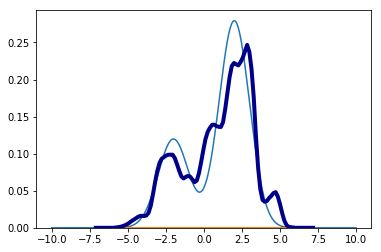

In [16]:
plt.plot(np.linspace(-10, 10, 1000), pdf)
plt.plot(real_samples, np.zeros_like(real_samples))
sns.kdeplot(real_samples, kernel='tri', color='darkblue', linewidth=4)

In [37]:
def plot_projections(dm=None, use_real=True, kernel='tri'):
    N_plots = None
    scale_factor = None
    
    if use_real:
        if not dm.use_latent:
            return
        N_plots = dm.lt.A.shape[0]
    else:
        N_plots = dm.particles.shape[0]
    if N_plots > 6:
        scale_factor = 15
    else:
        scale_factor = 5
        
    N_plots = min(N_plots, 1)
        
    plt.figure(figsize=(3 * scale_factor, (N_plots // 3 + 1) * scale_factor))
    
    for idx in range(N_plots):
        slice_dim = idx
        
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        
        particles = None
        if use_real:
            particles = dm.lt.transform(dm.particles, n_particles_second=True).t()[:, slice_dim]
        else:
            particles = dm.particles.t()[:, slice_dim]
        
        plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
        plt.plot(particles.data.cpu().numpy(), torch.zeros_like(particles).data.cpu().numpy(), 'ro')
        sns.kdeplot(particles.data.cpu().numpy(), 
                    kernel=kernel, color='darkblue', linewidth=4)

In [38]:
plot_projections(dm, use_real=True)

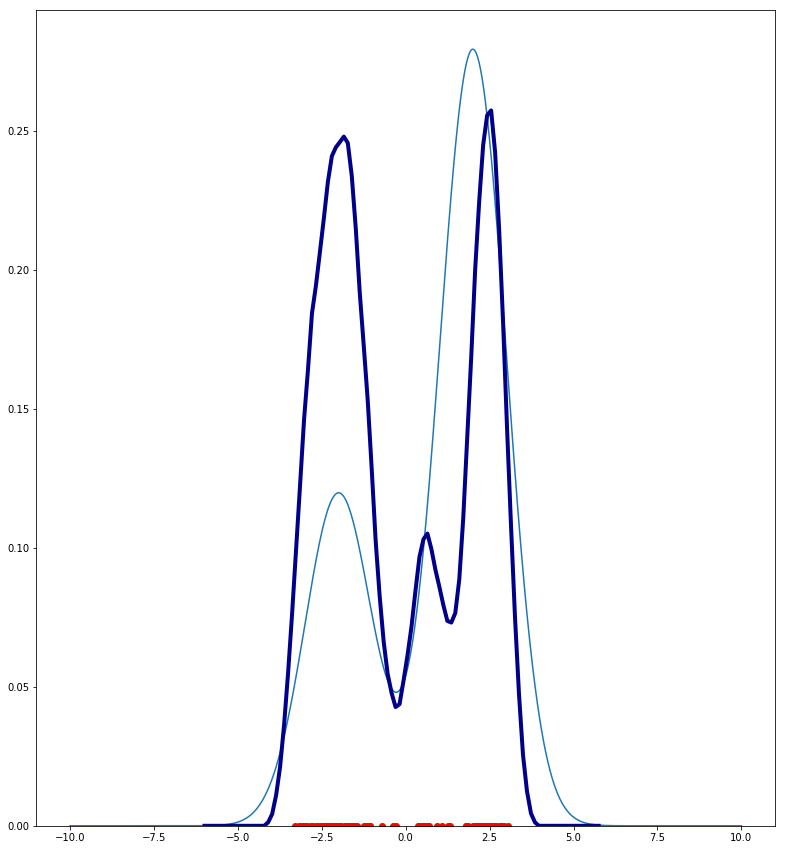

In [39]:
plot_projections(dm, use_real=False)

In [42]:
dm = DistributionMover(n_particles=1000, n_dims=20, n_hidden_dims=20, use_latent=False)

In [ ]:
# %%time

for _ in range(3000): 
    try:
        dm.update_latent(h_type=0, kernel_type='rbf', p=-1)

        if _ % 1 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

            plot_projections(dm, use_real=True, kernel='tri')
            plot_projections(dm, use_real=False, kernel='tri')

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
(torch.mean(dm.lt.transform(dm.particles, n_particles_second=True)),
 torch.mean(torch.std(dm.lt.transform(dm.particles, n_particles_second=True), dim=1) ** 2))

# Compare implementations of Stein Gradients

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = h / np.log(theta.shape[0]+1)

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = 2. * dxkxy / (h)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print( 'iter ' + str(iter+1) )
            
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = bandwidth)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta

In [ ]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, n_hidden_dims=20, use_latent=False)

In [ ]:
dm_svgd = SVGD()

In [ ]:
def lnprob(particles):
    grad_log_term = torch.zeros([particles.shape[0], particles.shape[1]], dtype=t_type)
    if use_cuda:
        grad_log_term = grad_log_term.cuda()
        
    for idx in range(100):
        particle = torch.tensor(particles[idx:idx+1], dtype=t_type, requires_grad=True)
        log_term = torch.log(dm_ex.target_density(particle.t()))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                     only_inputs=True, retain_graph=False, 
                                                     create_graph=False, allow_unused=False)[0]
    return grad_log_term

In [ ]:
result = dm_ex.particles.data.clone().detach().t()

In [ ]:
## Compare kernel implementation

ker, grad_ker = dm_ex.calc_kernel_term_latent(10.)
print(dm_ex.h)
grad_ker_sum = torch.sum(grad_ker, dim=1)

ker_l, grad_ker_sum_l = dm_svgd.svgd_kernel(result, h=10.)

print((ker - torch.tensor(ker_l)).norm())
print((grad_ker_sum - torch.tensor(grad_ker_sum_l).t()).norm())

In [ ]:
## Compare log_term implementation

(lnprob(result) - dm_ex.calc_log_term_latent().t()).norm()

In [ ]:
for _ in range(201): 
    try:
        result = dm_svgd.update(result, lnprob, stepsize=1e-2, bandwidth=-1, n_iter=20)
        result = torch.tensor(result, dtype=t_type)

        if _ % 1 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

            plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
            plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
            sns.kdeplot(result.data.cpu().numpy()[:,0], 
                        kernel='tri', color='darkblue', linewidth=4)

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
%%time

for _ in range(2000): 
    try:
        dm_ex.update_latent(h_type=0)

        if _ % 30 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm_ex.h))
            
            plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
            plt.plot(dm_ex.particles.t().data.cpu().numpy(), torch.zeros_like(dm_ex.particles.t()).data.cpu().numpy(), 'ro')
            sns.kdeplot(dm_ex.particles.t().data.cpu().numpy()[:,0], 
                        kernel='tri', color='darkblue', linewidth=4)

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
(result - dm_ex.particles.t()).norm()

# Logistic Regression from original paper

In [ ]:
sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
import numpy as np
import scipy.io
from sklearn.cross_validation import train_test_split
import numpy.matlib as nm
from svgd import SVGD

r'''
    Example of Bayesian Logistic Regression (the same setting as Gershman et al. 2012):
    The observed data D = {X, y} consist of N binary class labels, 
    y_t \in {-1,+1}, and d covariates for each datapoint, X_t \in R^d.
    The hidden variables \theta = {w, \alpha} consist of d regression coefficients w_k \in R,
    and a precision parameter \alpha \in R_+. We assume the following model:
        p(\alpha) = Gamma(\alpha; a, b)
        p(w_k | a) = N(w_k; 0, \alpha^-1)
        p(y_t = 1| x_t, w) = 1 / (1+exp(-w^T x_t))
'''
class BayesianLR:
    def __init__(self, X, Y, batchsize=100, a0=1, b0=0.01):
        self.X, self.Y = X, Y
        # TODO. Y in \in{+1, -1}
        self.batchsize = min(batchsize, X.shape[0])
        self.a0, self.b0 = a0, b0
        
        self.N = X.shape[0]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0
    
        
    def dlnprob(self, theta):
        
        if self.batchsize > 0:
            batch = [ i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize) ]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])
            
        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]
        
        w = theta[:, :-1]  # logistic weights
        alpha = np.exp(theta[:, -1])  # the last column is logalpha
        d = w.shape[1]
        
        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))
        
        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))
        
        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d) , w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale
        
        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term
        
        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative 
    
    def evaluation(self, theta, X_test, y_test):
        theta = theta[:, :-1]
        M, n_test = theta.shape[0], len(y_test)

        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = np.divide(np.ones(n_test), (1 + np.exp(coff)))
        
        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        llh = np.mean(np.log(prob))
        return [acc, llh]

In [ ]:
N = X_test.shape[0] + X_train.shape[0]
X_input = np.hstack([X, np.ones([N, 1])])
y_input = y
d = X_input.shape[1]
D = d + 1
    
# split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)
    
a0, b0 = 1, 0.01 #hyper-parameters
model = BayesianLR(X_train, y_train, 100, a0, b0) # batchsize = 100
    
# initialization
M = 100  # number of particles
theta0 = np.zeros([M, D]);
alpha0 = np.random.gamma(a0, b0, M); 
for i in range(M):
    theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])
    
theta = SVGD().update(x0=theta0, lnprob=model.dlnprob, bandwidth=-1, n_iter=6000, stepsize=0.05, alpha=0.9, debug=True)
    
print('[accuracy, log-likelihood]')
print(model.evaluation(theta, X_test, y_test))

# Metropolis–Hastings algorithm 

In [ ]:
class MHAlgorithm():
    def __init__(self, n_dims): 
        self.n_dims = n_dims
        
        self.target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs) +
                                                           0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs))

        self.real_target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True)(x, *args, **kwargs) +
                                                                0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True)(x, *args, **kwargs))
        
#         self.target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True).unnormed_density(x))

#         self.real_target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True)(x))

    
        self.particles = torch.zeros(
            [self.n_dims, 1],
            dtype=t_type,
            requires_grad=False,
            device=device).uniform_(-2., -1.)
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        
    def generate_next(self):
        previous = self.particles[:, -1].unsqueeze(1)
#         self.additional_distribution = normal_density(self.n_dims, previous, 1, n_particles_second=True)
#         candidate = self.additional_distribution.get_sample()
        
#         alpha = (self.target_density(candidate) * self.additional_distribution.unnormed_density(previous) / 
#                 (self.target_density(previous) * self.additional_distribution.unnormed_density(candidate)))
        candidate = previous + torch.zeros([self.n_dims, 1], device=device, dtype=t_type).uniform_(-1., 1.)
        alpha = self.target_density(candidate) / self.target_density(previous)
        
#         print(self.target_density(candidate)[0].data.numpy(), self.additional_distribution.unnormed_density(previous)[0].data.numpy(),
#               self.target_density(previous)[0].data.numpy(), self.additional_distribution.unnormed_density(candidate)[0].data.numpy())
        
        if alpha > self.one:
            self.particles = torch.cat([self.particles, candidate], dim=1)
        else:
            random = torch.bernoulli(alpha)
            if random:
                self.particles = torch.cat([self.particles, candidate], dim=1)                
            else:
                self.particles = torch.cat([self.particles, previous], dim=1)

In [ ]:
mh = MHAlgorithm(3)

In [ ]:
for _ in range(10000):
    mh.generate_next()

In [ ]:
sns.kdeplot(mh.particles.t().data.cpu().numpy()[:,1], 
            kernel='tri', color='darkblue', linewidth=4)

In [ ]:
hist_plot(mh.particles.t().data.cpu().numpy()[:,1])

In [ ]:
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time

mu,sig,N = 0,1,1000000
pts = []

def q(x):
#     return (1/(math.sqrt(2*math.pi*sig**2)))*(math.e**(-((x-mu)**2)/(2*sig**2)))
#     return normal_density(1, 0., 2., n_particles_second=True).unnormed_density(x)
    return (0.3 * normal_density(1, -2., 1., n_particles_second=True).unnormed_density(x) +
            0.7 * normal_density(1, 2., 1., n_particles_second=True).unnormed_density(x))

def metropolis(N):
    r = np.zeros(1)
    p = q(r[0])
    pts = []
    
    for i in range(N):
        rn = r + np.random.uniform(-1,1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn/p:
                p = pn
                r = rn
        pts.append(r)
    
    pts = np.array(pts)
    return pts
    
def hist_plot(array):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,)
    ax.hist(array, bins=1000)    
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
hist_plot(metropolis(100000))

In [ ]:
gg =  lambda : (normal_density(1, -60., 20., n_particles_second=True).get_sample())

In [ ]:
hist_plot([gg()[0,0] for _ in range(1000000)])